# Chapter 7. Ulysses’ Compass

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, ops, random, vmap
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

from src import utils
%load_ext autoreload
%autoreload 2

### Code 7.1

In [2]:
sppnames = [
    "afarensis",
    "africanus",
    "habilis",
    "boisei",
    "rudolfensis",
    "ergaster",
    "sapiens",
]
brainvolcc = jnp.array([438, 452, 612, 521, 752, 871, 1350])
masskg = jnp.array([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})

### Code 7.2

In [3]:
d["mass_std"] = (d.mass - d.mass.mean()) / d.mass.std()
d["brain_std"] = d.brain / d.brain.max()

### Code 7.3

In [4]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic("mu", a + b * mass_std)
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_1 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m7_1,
    optim.Adam(0.3),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
p7_1, losses = svi.run(random.PRNGKey(0), 1000).params, None

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2226.66it/s, init loss: 115.9437, avg. loss [951-1000]: 3.6841]


### Code 7.4

In [5]:
def model(mass_std, brain_std):
    intercept = numpyro.sample("intercept", dist.Normal(0, 10))
    b_mass_std = numpyro.sample("b_mass_std", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(2))
    mu = intercept + b_mass_std * mass_std
    numpyro.sample("brain_std", dist.Normal(mu, sigma), obs=brain_std)


m7_1_OLS = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m7_1_OLS,
    optim=optim.Adam(0.01),
    loss=Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
p7_1_OLS, losses = svi.run(random.PRNGKey(0), 1000).params, None
post = m7_1_OLS.sample_posterior(random.PRNGKey(1), p7_1_OLS, (1000,))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2712.06it/s, init loss: 118.9001, avg. loss [951-1000]: 6.6802]


### Code 7.5

In [6]:
post = m7_1.sample_posterior(random.PRNGKey(12), p7_1, (1000,))
s = Predictive(m7_1.model, post)(random.PRNGKey(2), d.mass_std.values)
r = jnp.mean(s["brain_std"], 0) - d.brain_std.values
resid_var = jnp.var(r, ddof=1)
outcome_var = jnp.var(d.brain_std.values, ddof=1)
1 - resid_var / outcome_var

Array(0.45558083, dtype=float32)

### Code 7.6

In [7]:
def R2_is_bad(quap_fit):
    quap, params = quap_fit
    post = quap.sample_posterior(random.PRNGKey(1), params, (1000,))
    s = Predictive(quap.model, post)(random.PRNGKey(2), d.mass_std.values)
    r = jnp.mean(s["brain_std"], 0) - d.brain_std.values
    return 1 - jnp.var(r, ddof=1) / jnp.var(d.brain_std.values, ddof=1)

### Code 7.7

In [8]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([2]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic("mu", a + b[0] * mass_std + b[1] * mass_std ** 2)
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_2 = AutoLaplaceApproximation(
    model, init_loc_fn=init_to_value(values={"b": jnp.repeat(0.0, 2)})
)
svi = SVI(
    model,
    m7_2,
    optim.Adam(0.3),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
p7_2, losses = svi.run(random.PRNGKey(0), 2000).params, None

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3703.56it/s, init loss: 19.0172, avg. loss [1901-2000]: 6.6279]


### Code 7.8

In [9]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([3]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + b[0] * mass_std + b[1] * mass_std ** 2 + b[2] * mass_std ** 3
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_3 = AutoLaplaceApproximation(
    model, init_loc_fn=init_to_value(values={"b": jnp.repeat(0.0, 3)})
)
svi = SVI(
    model,
    m7_3,
    optim.Adam(0.01),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
p7_3, losses = svi.run(random.PRNGKey(0), 2000).params, None


def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([4]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + jnp.sum(b * jnp.power(mass_std[..., None], jnp.arange(1, 5)), -1)
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_4 = AutoLaplaceApproximation(
    model, init_loc_fn=init_to_value(values={"b": jnp.repeat(0.0, 4)})
)
svi = SVI(
    model,
    m7_4,
    optim.Adam(0.01),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
p7_4, losses = svi.run(random.PRNGKey(0), 2000).params, None


def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([5]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + jnp.sum(b * jnp.power(mass_std[..., None], jnp.arange(1, 6)), -1)
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_5 = AutoLaplaceApproximation(
    model, init_loc_fn=init_to_value(values={"b": jnp.repeat(0.0, 5)})
)
svi = SVI(
    model,
    m7_5,
    optim.Adam(0.01),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
p7_5, losses = svi.run(random.PRNGKey(0), 2000).params, None

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3990.53it/s, init loss: 28.6818, avg. loss [1901-2000]: 8.2612]


### Code 7.9

In [10]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([6]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + jnp.sum(b * jnp.power(mass_std[..., None], jnp.arange(1, 7)), -1)
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_6 = AutoLaplaceApproximation(
    model, init_loc_fn=init_to_value(values={"b": jnp.repeat(0.0, 6)})
)
svi = SVI(
    model,
    m7_6,
    optim.Adam(0.003),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
p7_6, losses = svi.run(random.PRNGKey(0), 5000).params, None

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5169.73it/s, init loss: 31.9033, avg. loss [4751-5000]: 9.2853]


### Code 7.10

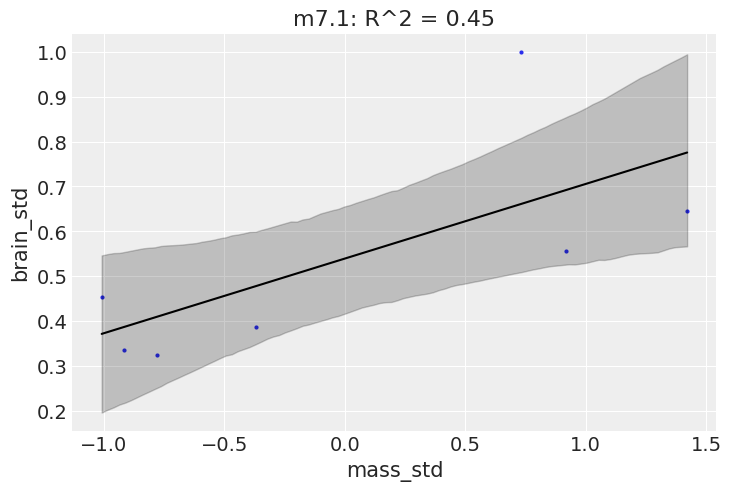

In [11]:
post = m7_1.sample_posterior(random.PRNGKey(1), p7_1, (1000,))
mass_seq = jnp.linspace(d.mass_std.min(), d.mass_std.max(), num=100)
l = Predictive(m7_1.model, post, return_sites=["mu"])(
    random.PRNGKey(2), mass_std=mass_seq
)["mu"]
mu = jnp.mean(l, 0)
ci = jnp.percentile(l, jnp.array((4.5, 95.5)), 0)
az.plot_pair(d[["mass_std", "brain_std"]].to_dict("list"))
plt.plot(mass_seq, mu, "k")
plt.fill_between(mass_seq, ci[0], ci[1], color="k", alpha=0.2)
plt.title("m7.1: R^2 = {:0.2f}".format(R2_is_bad((m7_1, p7_1)).item()))
plt.show()

### Code 7.11

In [12]:
i = 1
d_minus_i = d.drop(i)

### Code 7.12

In [13]:
p = jnp.array([0.3, 0.7])
-jnp.sum(p * jnp.log(p))

Array(0.61086434, dtype=float32)

### Code 7.13

In [14]:
def lppd_fn(seed, quad, params, num_samples=1000):
    post = quad.sample_posterior(random.PRNGKey(1), params, (int(1e4),))
    logprob = log_likelihood(quad.model, post, d.mass_std.values, d.brain_std.values)
    logprob = logprob["brain_std"]
    return logsumexp(logprob, 0) - jnp.log(logprob.shape[0])


lppd_fn(random.PRNGKey(1), m7_1, p7_1, int(1e4))

Array([ 0.60762596,  0.64879227,  0.5540371 ,  0.61943054,  0.45491314,
        0.42401695, -0.80657005], dtype=float32)

### Code 7.14

In [15]:
post = m7_1.sample_posterior(random.PRNGKey(1), p7_1, (int(1e4),))
logprob = log_likelihood(m7_1.model, post, d.mass_std.values, d.brain_std.values)
logprob = logprob["brain_std"]
n = logprob.shape[1]
ns = logprob.shape[0]
f = lambda i: logsumexp(logprob[:, i]) - jnp.log(ns)
lppd = vmap(f)(jnp.arange(n))
lppd

Array([ 0.60762596,  0.64879227,  0.5540371 ,  0.61943054,  0.4549141 ,
        0.42401695, -0.80657005], dtype=float32)

### Code 7.15

In [16]:
[
    jnp.sum(lppd_fn(random.PRNGKey(1), m[0], m[1])).item()
    for m in (
        (m7_1, p7_1),
        (m7_2, p7_2),
        (m7_3, p7_3),
        (m7_4, p7_4),
        (m7_5, p7_5),
        (m7_6, p7_6),
    )
]

[2.5022459030151367,
 2.5913963317871094,
 3.6697940826416016,
 5.341108322143555,
 14.092328071594238,
 19.87215232849121]

### Code 7.16

In [17]:
def model(mm, y, b_sigma):
    a = numpyro.param("a", jnp.array([0.0]))
    Bvec = a
    k = mm.shape[1]
    if k > 1:
        b = numpyro.sample("b", dist.Normal(0, b_sigma).expand([k - 1]))
        Bvec = jnp.concatenate([Bvec, b])
    mu = jnp.matmul(mm, Bvec)
    numpyro.sample("y", dist.Normal(mu, 1), obs=y)


def sim_train_test(i, N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    n_dim = max(k, 3)
    Rho = jnp.identity(n_dim)
    Rho = ops.index_update(Rho, ops.index[1 : len(rho) + 1, 0], jnp.array(rho))
    Rho = ops.index_update(Rho, ops.index[0, 1 : len(rho) + 1], jnp.array(rho))

    X_train = dist.MultivariateNormal(jnp.zeros(n_dim), Rho).sample(
        random.fold_in(random.PRNGKey(0), i), (N,)
    )
    mm_train = jnp.ones((N, 1))
    if k > 1:
        mm_train = jnp.concatenate([mm_train, X_train[:, 1:k]], axis=1)

    if k > 1:
        m = AutoLaplaceApproximation(
            model, init_loc_fn=init_to_value(values={"b": jnp.zeros(k - 1)})
        )
    else:
        m = lambda mm, y, b_sigma: None
    svi = SVI(
        model, m, optim.Adam(0.3), Trace_ELBO(), mm=mm_train, y=X_train[:, 0], b_sigma=b_sigma
    )
    params, losses = svi.run(random.fold_in(random.PRNGKey(1), i), 1000, progress_bar=False)
    coefs = params["a"]
    if k > 1:
        coefs = jnp.concatenate([coefs, m.median(params)["b"]])

    logprob = dist.Normal(jnp.matmul(mm_train, coefs)).log_prob(X_train[:, 0])
    dev_train = (-2) * jnp.sum(logprob)

    X_test = dist.MultivariateNormal(jnp.zeros(n_dim), Rho).sample(
        random.fold_in(random.PRNGKey(2), i), (N,)
    )
    mm_test = jnp.ones((N, 1))
    if k > 1:
        mm_test = jnp.concatenate([mm_test, X_test[:, 1:k]], axis=1)
    logprob = dist.Normal(jnp.matmul(mm_test, coefs)).log_prob(X_test[:, 0])
    dev_test = (-2) * jnp.sum(logprob)
    return jnp.stack([dev_train, dev_test])


def dev_fn(N, k):
    print(k)
    r = lax.map(lambda i: sim_train_test(i, N, k), jnp.arange((int(1e4))))
    return jnp.concatenate([jnp.mean(r, 0), jnp.std(r, 0)])


N = 20
kseq = range(1, 6)
dev = jnp.stack([dev_fn(N, k) for k in kseq], axis=1)

1


AttributeError: module 'jax.ops' has no attribute 'index_update'

### Code 7.17

In [ ]:
def dev_fn(N, k):
    print(k)
    r = vmap(lambda i: sim_train_test(i, N, k))(jnp.arange((int(1e4))))
    return jnp.concatenate([jnp.mean(r, 0), jnp.std(r, 0)])

### Code 7.18

In [ ]:
plt.subplot(
    ylim=(jnp.min(dev[0]).item() - 5, jnp.max(dev[0]).item() + 12),
    xlim=(0.9, 5.2),
    xlabel="number of parameters",
    ylabel="deviance",
)
plt.title("N = {}".format(N))
plt.scatter(jnp.arange(1, 6), dev[0], s=80, color="b")
plt.scatter(jnp.arange(1.1, 6), dev[1], s=80, color="k")
pts_int = (dev[0] - dev[2], dev[0] + dev[2])
pts_out = (dev[1] - dev[3], dev[1] + dev[3])
plt.vlines(jnp.arange(1, 6), pts_int[0], pts_int[1], color="b")
plt.vlines(jnp.arange(1.1, 6), pts_out[0], pts_out[1], color="k")
plt.annotate(
    "in", (2, dev[0][1]), xytext=(-25, -5), textcoords="offset pixels", color="b"
)
plt.annotate("out", (2.1, dev[1][1]), xytext=(10, -5), textcoords="offset pixels")
plt.annotate(
    "+1SD",
    (2.1, pts_out[1][1]),
    xytext=(10, -5),
    textcoords="offset pixels",
    fontsize=12,
)
plt.annotate(
    "-1SD",
    (2.1, pts_out[0][1]),
    xytext=(10, -5),
    textcoords="offset pixels",
    fontsize=12,
)
plt.show()

### Code 7.19

In [20]:
cars = pd.read_csv("../data/cars.csv", sep=",")


def model(speed, cars_dist):
    a = numpyro.sample("a", dist.Normal(0, 100))
    b = numpyro.sample("b", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + b * speed
    numpyro.sample("dist", dist.Normal(mu, sigma), obs=cars_dist)


m = AutoLaplaceApproximation(model)
svi = SVI(
    model, m, optim.Adam(1), Trace_ELBO(), speed=cars.speed.values, cars_dist=cars.dist.values
)
params, losses = svi.run(random.PRNGKey(0), 1000)
post = m.sample_posterior(random.PRNGKey(94), params, (1000,))

100%|██████████| 1000/1000 [00:00<00:00, 1220.71it/s, init loss: 210883.8125, avg. loss [951-1000]: 304.4745]


### Code 7.20

In [21]:
n_samples = 1000


def logprob_fn(s):
    mu = post["a"][s] + post["b"][s] * cars.speed.values
    return dist.Normal(mu, post["sigma"][s]).log_prob(cars.dist.values)


logprob = vmap(logprob_fn, out_axes=1)(jnp.arange(n_samples))

### Code 7.21

In [22]:
n_cases = cars.shape[0]
lppd = logsumexp(logprob, 1) - jnp.log(n_samples)

### Code 7.22

In [23]:
pWAIC = jnp.var(logprob, 1)

### Code 7.23

In [24]:
-2 * (jnp.sum(lppd) - jnp.sum(pWAIC))

DeviceArray(528.4768, dtype=float32)

### Code 7.24

In [25]:
waic_vec = -2 * (lppd - pWAIC)
jnp.sqrt(n_cases * jnp.var(waic_vec))

DeviceArray(6.914636, dtype=float32)

### Code 7.25

In [18]:
with numpyro.handlers.seed(rng_seed=71):
    # number of plants
    N = 100

    # simulate initial heights
    h0 = numpyro.sample("h0", dist.Normal(10, 2).expand([N]))

    # assign treatments and simulate fungus and growth
    treatment = jnp.repeat(jnp.arange(2), repeats=N // 2)
    fungus = numpyro.sample(
        "fungus", dist.Binomial(total_count=1, probs=(0.5 - treatment * 0.4))
    )
    h1 = h0 + numpyro.sample("diff", dist.Normal(5 - 3 * fungus))

    # compose a clean data frame
    d = pd.DataFrame({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})


def model(h0, h1):
    p = numpyro.sample("p", dist.LogNormal(0, 0.25))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_6, optim.Adam(0.1), Trace_ELBO(), h0=d.h0.values, h1=d.h1.values)
p6_6, losses = svi.run(random.PRNGKey(0), 1000).params, None


def model(treatment, fungus, h0, h1):
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))
    bf = numpyro.sample("bf", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment + bf * fungus
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_7 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_7,
    optim.Adam(0.3),
    Trace_ELBO(),
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
p6_7, losses = svi.run(random.PRNGKey(0), 1000).params, None


def model(treatment, h0, h1):
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_8 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_8,
    optim.Adam(1),
    Trace_ELBO(),
    treatment=d.treatment.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
p6_8, losses = svi.run(random.PRNGKey(0), 1000).params, None

post = m6_7.sample_posterior(random.PRNGKey(11), p6_7, (1000,))
logprob = log_likelihood(
    m6_7.model,
    post,
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
az6_7 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
az.waic(az6_7, scale="deviance")

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2675.05it/s, init loss: 87469.1172, avg. loss [951-1000]: 198.4736]
See http://arxiv.org/abs/1507.04544 for details


Computed from 1000 posterior samples and 100 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   337.37    11.86
p_waic            3.36        -

There has been a warning during the calculation. Please check the results.

### Code 7.26

In [19]:
post = m6_6.sample_posterior(random.PRNGKey(77), p6_6, (1000,))
logprob = log_likelihood(m6_6.model, post, h0=d.h0.values, h1=d.h1.values)
az6_6 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
post = m6_7.sample_posterior(random.PRNGKey(77), p6_7, (1000,))
logprob = log_likelihood(
    m6_7.model,
    post,
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
az6_7 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
post = m6_8.sample_posterior(random.PRNGKey(77), p6_8, (1000,))
logprob = log_likelihood(
    m6_8.model, post, treatment=d.treatment.values, h0=d.h0.values, h1=d.h1.values
)
az6_8 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
az.compare({"m6.6": az6_6, "m6.7": az6_7, "m6.8": az6_8}, ic="waic", scale="deviance")

See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m6.7,0,337.244355,3.308167,0.000000,1.000000e+00,11.844577,0.000000,True,deviance
m6.8,1,399.758478,3.089428,62.514124,0.000000e+00,14.941817,13.865608,True,deviance
m6.6,2,409.200461,1.712101,71.956106,4.295475e-11,12.403869,12.791192,False,deviance


### Code 7.27

In [21]:
post = m6_7.sample_posterior(random.PRNGKey(91), p6_7, (1000,))
logprob = log_likelihood(
    m6_7.model,
    post,
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
az6_7 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_7 = az.waic(az6_7, pointwise=True, scale="deviance")
post = m6_8.sample_posterior(random.PRNGKey(91), p6_8, (1000,))
logprob = log_likelihood(
    m6_8.model, post, treatment=d.treatment.values, h0=d.h0.values, h1=d.h1.values
)
az6_8 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_8 = az.waic(az6_8, pointwise=True, scale="deviance")
n = waic_m6_7.n_data_points
diff_m6_7_m6_8 = waic_m6_7.waic_i.values - waic_m6_8.waic_i.values
jnp.sqrt(n * jnp.var(diff_m6_7_m6_8))

See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details


Array(13.789174, dtype=float32)

### Code 7.28

In [22]:
40.0 + jnp.array([-1, 1]) * 10.4 * 2.6

Array([12.960003, 67.03999 ], dtype=float32, weak_type=True)

### Code 7.29

See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details


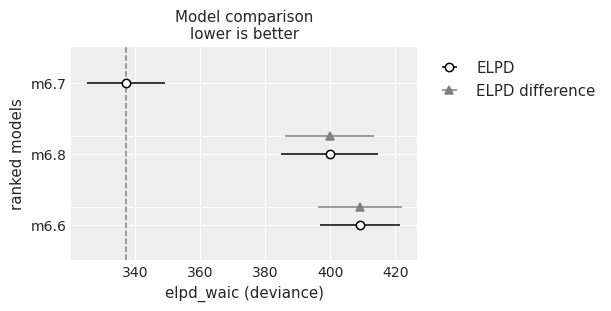

In [23]:
compare = az.compare(
    {"m6.6": az6_6, "m6.7": az6_7, "m6.8": az6_8}, ic="waic", scale="deviance"
)
az.plot_compare(compare)
plt.show()

### Code 7.30

In [24]:
post = m6_6.sample_posterior(random.PRNGKey(92), p6_6, (1000,))
logprob = log_likelihood(m6_6.model, post, h0=d.h0.values, h1=d.h1.values)
az6_6 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_6 = az.waic(az6_6, pointwise=True, scale="deviance")
diff_m6_6_m6_8 = waic_m6_6.waic_i.values - waic_m6_8.waic_i.values
jnp.sqrt(n * jnp.var(diff_m6_6_m6_8))

Array(7.5247483, dtype=float32)

### Code 7.31

In [25]:
post = m6_6.sample_posterior(random.PRNGKey(93), p6_6, (1000,))
logprob = log_likelihood(m6_6.model, post, h0=d.h0.values, h1=d.h1.values)
az6_6 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_6 = az.waic(az6_6, pointwise=True, scale="deviance")
post = m6_7.sample_posterior(random.PRNGKey(93), p6_7, (1000,))
logprob = log_likelihood(
    m6_7.model,
    post,
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
az6_7 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_7 = az.waic(az6_7, pointwise=True, scale="deviance")
post = m6_8.sample_posterior(random.PRNGKey(93), p6_8, (1000,))
logprob = log_likelihood(
    m6_8.model, post, treatment=d.treatment.values, h0=d.h0.values, h1=d.h1.values
)
az6_8 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
waic_m6_8 = az.waic(az6_8, pointwise=True, scale="deviance")
dSE = lambda waic1, waic2: jnp.sqrt(
    n * jnp.var(waic1.waic_i.values - waic2.waic_i.values)
)
data = {"m6.6": waic_m6_6, "m6.7": waic_m6_7, "m6.8": waic_m6_8}
pd.DataFrame(
    {
        row: {col: dSE(row_val, col_val) for col, col_val in data.items()}
        for row, row_val in data.items()
    }
)

See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details


,m6.6,m6.7,m6.8
m6.6,0.0,12.709704,7.558754
m6.7,12.709704,0.0,13.690909
m6.8,7.558754,13.690909,0.0


### Code 7.32

In [26]:
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())


def model(A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), Trace_ELBO(), A=d.A.values, D=d.D.values)
p5_1, losses = svi.run(random.PRNGKey(0), 1000).params, None


def model(M, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), Trace_ELBO(), M=d.M.values, D=d.D.values)
p5_2, losses = svi.run(random.PRNGKey(0), 1000).params, None


def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_3, optim.Adam(1), Trace_ELBO(), M=d.M.values, A=d.A.values, D=d.D.values)
p5_3, losses = svi.run(random.PRNGKey(0), 1000).params, None

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2399.08it/s, init loss: 3201.7393, avg. loss [951-1000]: 60.7879]


### Code 7.33

In [27]:
post = m5_1.sample_posterior(random.PRNGKey(24071847), p5_1, (1000,))
logprob = log_likelihood(m5_1.model, post, A=d.A.values, D=d.D.values)["D"]
az5_1 = az.from_dict(
    posterior={k: v[None, ...] for k, v in post.items()},
    log_likelihood={"D": logprob[None, ...]},
)
post = m5_2.sample_posterior(random.PRNGKey(24071847), p5_2, (1000,))
logprob = log_likelihood(m5_2.model, post, M=d.M.values, D=d.D.values)["D"]
az5_2 = az.from_dict(
    posterior={k: v[None, ...] for k, v in post.items()},
    log_likelihood={"D": logprob[None, ...]},
)
post = m5_3.sample_posterior(random.PRNGKey(24071847), p5_3, (1000,))
logprob = log_likelihood(m5_3.model, post, A=d.A.values, M=d.M.values, D=d.D.values)[
    "D"
]
az5_3 = az.from_dict(
    posterior={k: v[None, ...] for k, v in post.items()},
    log_likelihood={"D": logprob[None, ...]},
)
az.compare({"m5.1": az5_1, "m5.2": az5_2, "m5.3": az5_3}, ic="waic", scale="deviance")

See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m5.1,0,126.515837,4.108172,0.000000,0.88796,13.580525,0.000000,True,deviance
m5.3,1,128.609598,5.490679,2.093761,0.00000,14.173849,1.047469,True,deviance
m5.2,2,139.775920,3.282652,13.260084,0.11204,10.458671,9.845426,True,deviance


### Code 7.34

See http://arxiv.org/abs/1507.04544 for details


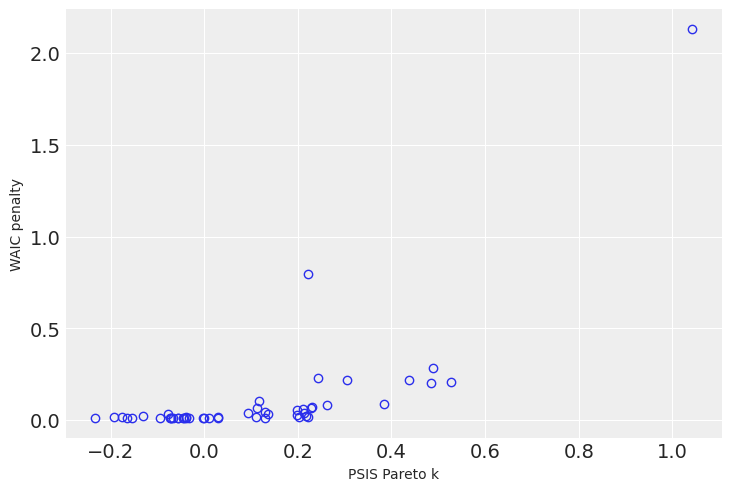

In [28]:
PSIS_m5_3 = az.loo(az5_3, pointwise=True, scale="deviance")
WAIC_m5_3 = az.waic(az5_3, pointwise=True, scale="deviance")
penalty = az5_3.log_likelihood.stack(sample=("chain", "draw")).var(dim="sample")
plt.plot(PSIS_m5_3.pareto_k.values, penalty.D.values, "o", mfc="none")
plt.gca().set(xlabel="PSIS Pareto k", ylabel="WAIC penalty")
plt.show()

### Code 7.35

In [29]:
def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    numpyro.sample("D", dist.StudentT(2, mu, sigma), obs=D)


m5_3t = AutoLaplaceApproximation(model)
svi = SVI(
    model, m5_3t, optim.Adam(0.3), Trace_ELBO(), M=d.M.values, A=d.A.values, D=d.D.values
)
p5_3t, losses = svi.run(random.PRNGKey(0), 1000).params, None

post = m5_3t.sample_posterior(random.PRNGKey(24071847), p5_3t, (1000,))
logprob = log_likelihood(m5_3t.model, post, A=d.A.values, M=d.M.values, D=d.D.values)[
    "D"
]
az5_3t = az.from_dict(
    posterior={k: v[None, ...] for k, v in post.items()},
    log_likelihood={"D": logprob[None, ...]},
)

PSIS_m5_3t = az.loo(az5_3t, pointwise=True, scale="deviance")
WAIC_m5_3t = az.waic(az5_3t, pointwise=True, scale="deviance")
penalty = az5_3t.log_likelihood.stack(sample=("chain", "draw")).var(dim="sample")
plt.plot(PSIS_m5_3t.pareto_k.values, penalty.D.values, "o", mfc="none")
plt.gca().set(xlabel="PSIS Pareto k", ylabel="WAIC penalty")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1957.59it/s, init loss: 194.5655, avg. loss [951-1000]: 63.3271]


## Assignments

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, ops, random, vmap
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

from src import utils
%load_ext autoreload
%autoreload 2

In [2]:
laffer = pd.read_csv("../data/laffer.csv", sep=";").pipe(lambda d: (d - d.mean(axis=0))/d.std(axis=0))
laffer.head()

rate, revenue = laffer["tax_rate"].values, laffer["tax_revenue"].values

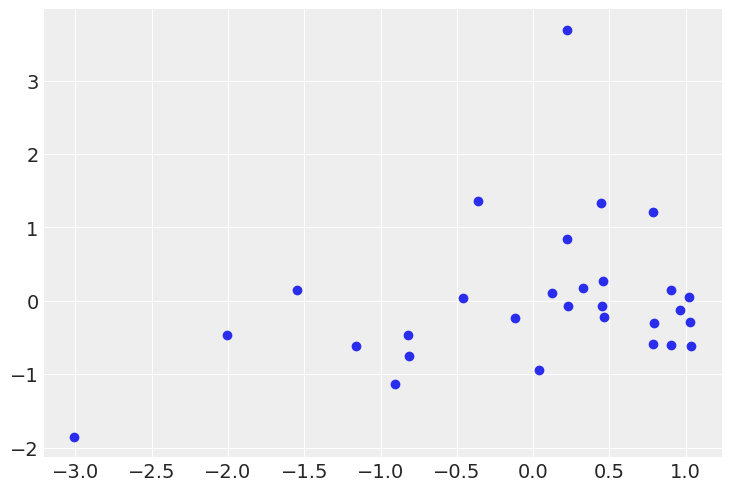

In [3]:
plt.scatter(rate, revenue);

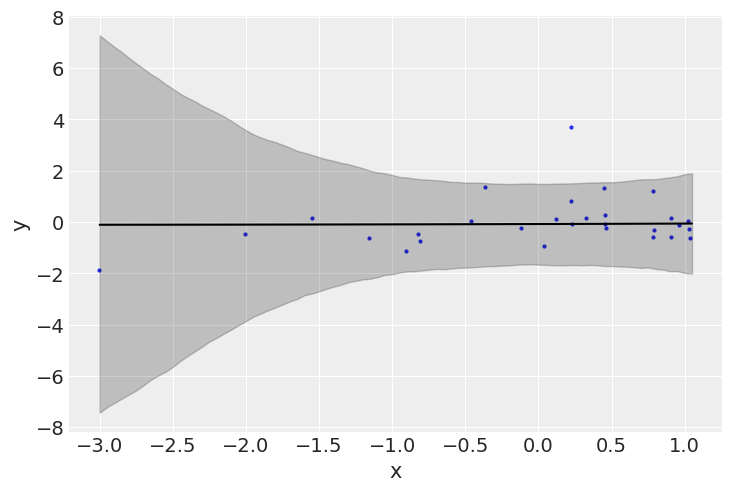

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2362.49it/s, init loss: 117.7356, avg. loss [951-1000]: 34.1617]


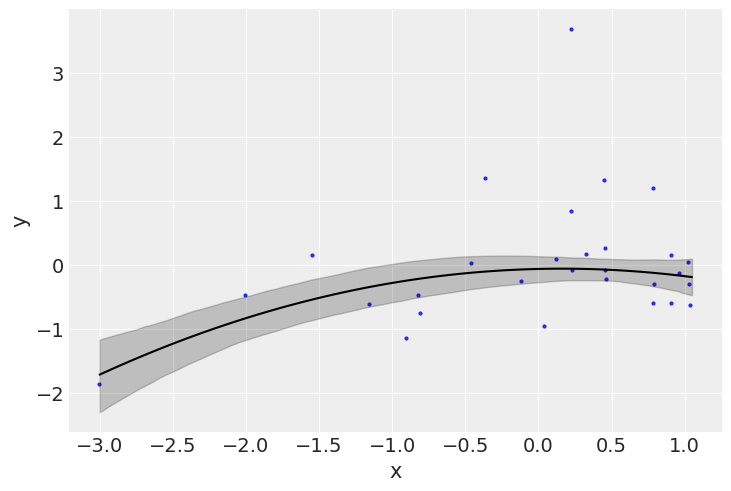


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.06      0.13     -0.06     -0.28      0.16    984.74      1.00
       b^1      0.05      0.14      0.05     -0.16      0.30    873.08      1.00
       b^2     -0.17      0.07     -0.16     -0.28     -0.05    949.50      1.00
     sigma      0.43      0.09      0.42      0.29      0.58    920.60      1.00



Inference data with groups:
	> posterior
	> log_likelihood

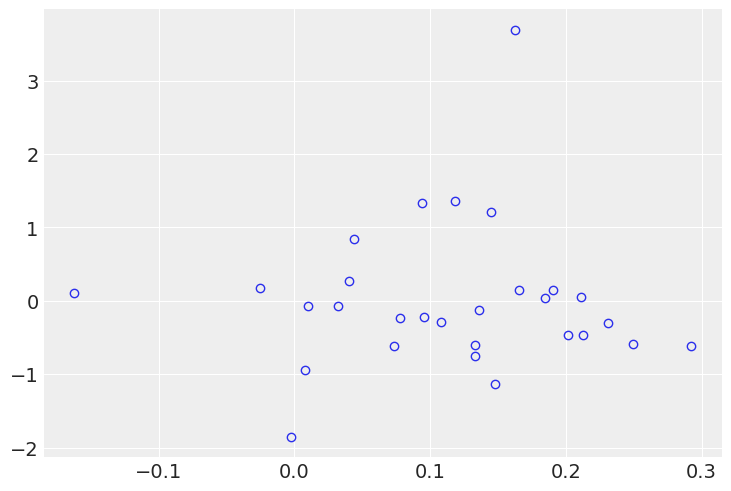

In [46]:
from functools import partial


def plot_prior_predictive(guide, var_name="mu", values=(-2, 2), ylim=(-2, 2), x_true=None, y_true=None):
    predictive = Predictive(guide.model, num_samples=1000, return_sites=["mu"])
    prior_pred = predictive(random.PRNGKey(10), jnp.array(values))
        
    mu = prior_pred["mu"]
    mu_mean = jnp.mean(mu, 0)
    mu_PI = jnp.percentile(mu, q=jnp.array((5.5, 94.5)), axis=0)
    
    if x_true is not None and y_true is not None:
        az.plot_pair({"x": x_true, "y": y_true})
    
    plt.plot(values, mu_mean, "k")
    plt.fill_between(values, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
    plt.show()
        

def plot_posterior_predictive(guide, params, values=(-2, 2), ylim=(-2, 2), x_true=None, y_true=None):
    post = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
    post_pred = Predictive(guide.model, post)(random.PRNGKey(2), values)

    mu = post_pred["mu"]
    mu_mean = jnp.mean(mu, 0)
    mu_PI = jnp.percentile(mu, q=jnp.array((5.5, 94.5)), axis=0)

    # plot it all
    if x_true is not None and y_true is not None:
        az.plot_pair({"x": x_true, "y": y_true})
    plt.plot(values, mu_mean, "k")
    plt.fill_between(values, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
    plt.show()


def laffer_model_(rate, revenue=None, polynomial=1, alpha_sigma=1, beta_sigma=0.5, student=True):
    mu = numpyro.sample("a", dist.Normal(0, alpha_sigma)) * jnp.ones_like(rate)
    for power in range(1, polynomial+1):
        mu += numpyro.sample(f"b^{power}", dist.Normal(0, beta_sigma)) * jnp.power(rate, power)
    
    mu_ = numpyro.deterministic("mu", mu)
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    if student:
        numpyro.sample("revenue", dist.StudentT(2, mu_, sigma), obs=revenue)
    else:
        numpyro.sample("revenue", dist.Normal(mu_, sigma), obs=revenue)
    return


def fit_laffer(laffer_model, plot=False):
    guide = AutoLaplaceApproximation(laffer_model)
    if plot:
        plot_prior_predictive(guide, values=jnp.arange(-3, 1.1, 0.05), x_true=rate, y_true=revenue)

    svi = SVI(
        laffer_model, guide, optim.Adam(0.3), Trace_ELBO(), rate=rate, revenue=revenue
    )
    params = svi.run(random.PRNGKey(0), 1000).params
    
    posterior = guide.sample_posterior(random.PRNGKey(2), params, (1000,))
    logprob = log_likelihood(guide.model, posterior, rate=rate, revenue=revenue)[
        "revenue"
    ]
    
    az_values = az.from_dict(
        posterior={k: v[None, ...] for k, v in posterior.items()},
        log_likelihood={"revenue": logprob[None, ...]},
    )
    
    if plot:
        plot_posterior_predictive(guide, params, x_true=rate, y_true=revenue, values=jnp.arange(-3, 1.1, 0.05))
        utils.print_filtered_summary(posterior, group_by_chain=False)
        
        PSIS = az.loo(az_values, pointwise=True, scale="deviance")
        penalty = az_values.log_likelihood.stack(sample=("chain", "draw")).var(dim="sample")
        plt.plot(PSIS.pareto_k.values, revenue, "o", mfc="none")
    
    return az_values
    
fit_laffer(partial(laffer_model_, polynomial=2, student=True), plot=True)


In [42]:
comp = az.compare({
    "p0_normal": fit_laffer(partial(laffer_model_, polynomial=0, student=False)),
    "p1_normal": fit_laffer(partial(laffer_model_, polynomial=1, student=False)),
    "p2_normal": fit_laffer(partial(laffer_model_, polynomial=2, student=False)),
    "p3_normal": fit_laffer(partial(laffer_model_, polynomial=3, student=False)),
    "p0_student": fit_laffer(partial(laffer_model_, polynomial=0, student=True)),
    "p1_student": fit_laffer(partial(laffer_model_, polynomial=1, student=True)),
    "p2_student": fit_laffer(partial(laffer_model_, polynomial=2, student=True)),
    "p3_student": fit_laffer(partial(laffer_model_, polynomial=3, student=True)),
}, ic="waic", scale="deviance")

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2191.99it/s, init loss: 105.8664, avg. loss [951-1000]: 34.9336]
See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details
See http://arxiv.org/abs/1507.04544 for details


In [43]:
comp

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
p2_student,0,69.904408,3.353168,0.000000,8.518199e-01,13.156876,0.000000,False,deviance
p1_student,1,73.838179,3.483254,3.933772,0.000000e+00,13.058934,4.158831,True,deviance
p0_student,2,74.536513,2.125604,4.632105,0.000000e+00,13.281974,5.700023,False,deviance
p3_student,3,77.750021,6.540297,7.845613,0.000000e+00,13.376384,4.001687,True,deviance
p2_normal,4,86.977512,6.107987,17.073104,1.481801e-01,21.348351,13.345793,True,deviance
p3_normal,5,87.257596,6.598416,17.353188,1.110248e-15,20.796317,12.877445,True,deviance
p1_normal,6,89.230441,6.172883,19.326033,4.716607e-16,21.584536,13.706018,True,deviance
p0_normal,7,89.649803,4.990915,19.745395,0.000000e+00,19.563933,12.175730,True,deviance


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

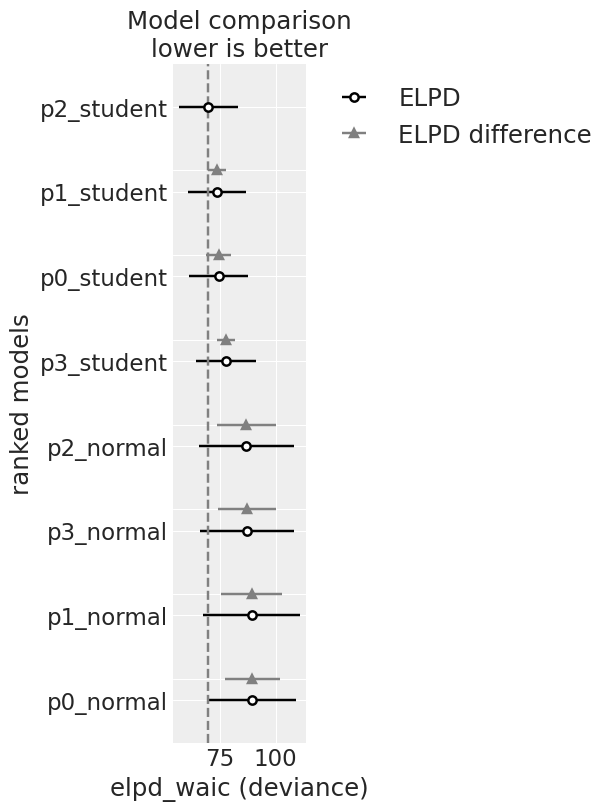

In [44]:
az.plot_compare(comp)